# **Лабораторна робота 6. Використання ансамблів для класифікації у банківській справі. Олескевич Софія, КН-314**


# **Використання ансамблів для класифікації у банківській справі**

Метою цієї лабораторної роботи є розробка різних типів класифікаторів на основі штучного інтелекту та їх ансамблів для класифікації клієнтів у банківській справі.
Після виконання цієї лабораторної роботи ви зможете:

1. порівняти різні типи класифікаторів
2. створити ансамбль моделей
3. створити ансамбль класифікатора на основі нейронних мереж
4. зробити класифікацію клієнтів на основі розроблених моделей


Імпортуємо бібліотеки та ставимо потрібне форматування


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)
# Data transformation
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
# Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
# warnings deactivate
import warnings
warnings.filterwarnings('ignore')


pd.set_option("precision", 2)
pd.options.display.float_format = '{:.2f}'.format

## Підготовка DataSet

 Будемо використовувати той самий DataSet, що й у попередній лабораторній роботі. Тому деякі кроки буде згруповано в один блок.

In [2]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep = ';')
# Transform to categorical data
col_cat = list(df.select_dtypes(include=['object']).columns)
df.loc[:, col_cat] = df[col_cat].astype('category')
# Create DataSets
X = df.iloc[:,:-1]  #input columns
y = df.iloc[:,-1]    #target column
# Encoding
col_cat.pop()
oe = OrdinalEncoder()
oe.fit(X[col_cat])
X_cat_enc = oe.transform(X[col_cat])
X_cat_enc = pd.DataFrame(X_cat_enc)
X_cat_enc.columns = col_cat
# Normalization
col_num = list(df.select_dtypes(include =['int64', 'float64']).columns)
scaler = MinMaxScaler(feature_range=(0, 1))
X_num_enc = scaler.fit_transform(X[col_num])
X_num_enc = pd.DataFrame(X_num_enc)
X_num_enc.columns = col_num
x_enc = pd.concat([X_cat_enc, X_num_enc], axis=1)
# Encoding target
le = LabelEncoder()
le.fit(y)
y_enc = le.transform(y)
y_enc = pd.Series(y_enc)
y_enc.columns = y.name
# Remove correlated fields
col = list(x_enc.columns)
col.remove('emp.var.rate')
col.remove('nr.employed')
x_enc = x_enc[col]
# Feature selection
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x_enc,y_enc)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x_enc.columns)
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
x_enc = x_enc[list(featureScores.nlargest(10,'Score')['Specs'])]
print(x_enc)
print(y_enc)

       euribor3m  contact  previous  duration  default  education  pdays  \
0           0.96     1.00      0.00      0.05     0.00       0.00   1.00   
1           0.96     1.00      0.00      0.03     1.00       3.00   1.00   
2           0.96     1.00      0.00      0.05     0.00       3.00   1.00   
3           0.96     1.00      0.00      0.03     0.00       1.00   1.00   
4           0.96     1.00      0.00      0.06     0.00       3.00   1.00   
...          ...      ...       ...       ...      ...        ...    ...   
41183       0.09     0.00      0.00      0.07     0.00       5.00   1.00   
41184       0.09     0.00      0.00      0.08     0.00       5.00   1.00   
41185       0.09     0.00      0.00      0.04     0.00       6.00   1.00   
41186       0.09     0.00      0.00      0.09     0.00       5.00   1.00   
41187       0.09     0.00      0.14      0.05     0.00       5.00   1.00   

       poutcome  job  cons.price.idx  
0          1.00 3.00            0.70  
1        

 В результаті отримано готовий DataSet, який можна використовувати для подальшої класифікації клієнтів банку.

## Класичні класифікаційні моделі

Імпортуємо бібліотеки

In [3]:
#Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

Для визначення точності моделі можна використовувати два підходи. Перший - розділити набір даних на навчальний та тестовий. Це було показано у попередній лабораторній роботі. Другий – оцінити результат шляхом перехресної валідації.

[Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), іноді називається перехресним тестуванням або тестуванням поза вибіркою, - це будь-який з різних аналогічних методів перевірки моделі для оцінки того, як результати статистичного аналізу будуть узагальнені на незалежний набір даних. Він в основному використовується в ситуаціях, коли метою є прогнозування і необхідно оцінити, наскільки точно прогностична модель працюватиме на практиці. Мета перехресної валідації - перевірити здатність моделі передбачати нові дані, які не використовувалися для її оцінки, щоб знайти такі проблеми, як надмірне припасування або усунення відбору, і дати уявлення про те, як модель узагальнюватиметься на незалежний набір даних (тобто невідомий) набір даних, наприклад, із реальної проблеми.

Один з етапів перехресної валідації передбачає розбиття вибірки даних на взаємодоповнюючі підмножини, виконання аналізу на одній підмножині (що називається навчальною множиною) і перевірку аналізу на іншій підмножині (називається валідаційною або тестовою множиною). Для зменшення варіативності у більшості методів проводиться кілька раундів перехресної валідації з використанням різних поділів, а результати валідації поєднуються (наприклад, усереднюються) за всіма раундами, щоб отримати оцінку прогностичної ефективності моделі.

Загалом крос-валідація поєднує (усереднює) міри придатності у прогнозуванні для отримання більш точної оцінки ефективності прогнозування моделі.

 Використаємо **[cross_val_score()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)** для оцінки точності будь-якого класифікатора від **sklearn** framework.

Протестуємо на LogisticRegression()

In [4]:
clf = LogisticRegression()
scores = cross_val_score(clf, x_enc, y_enc, scoring='accuracy', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Logistic Regression'))

Accuracy: 0.87 (+/- 0.05) [Logistic Regression]


Щоб порівняти результати різних класифікаторів, давайте збережемо результати у списках::

In [5]:
clf_name = ['Logistic Regression']
clf_acc = [scores.mean()]

Як бачимо, точність непогана.

Спробуємо використовувати інші класифікатори і порівняємо їх точність.

Проведемо тестування:
* [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression)
* [Quadratic Discriminant Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html?highlight=quadraticdiscriminantanalysis#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis)
* [Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html?highlight=gaussiannb#sklearn.naive_bayes.GaussianNB)
* [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier)
* [Ada Boost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboostclassifier#sklearn.ensemble.AdaBoostClassifier)

In [6]:
clf1 = LogisticRegression(random_state=1)
clf2 = QuadraticDiscriminantAnalysis()
clf3 = GaussianNB()
clf4 = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf5 = AdaBoostClassifier()

for clf, label in zip([clf1, clf2, clf3, clf4, clf5], ['Logistic Regression', 'Quadratic Discriminant Analysis', 'naive Bayes', 'Random Forest',  'Ada Bust']):
     scores = cross_val_score(clf, x_enc, y_enc, scoring='accuracy', cv=5)
     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.87 (+/- 0.05) [Logistic Regression]
Accuracy: 0.83 (+/- 0.13) [Quadratic Discriminant Analysis]
Accuracy: 0.80 (+/- 0.15) [naive Bayes]
Accuracy: 0.67 (+/- 0.28) [Random Forest]
Accuracy: 0.61 (+/- 0.27) [Ada Bust]


## Ансамбль класичних класифікаційних моделей

Крім того, різні класифікатори можуть помилятися у різних ситуаціях. Тому, щоб компенсувати помилки один одного, необхідно використати ансамблі моделей на основі Voting Classifier.

 **[Voting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)** Це модель машинного навчання, яка навчається на ансамблі численних моделей і передбачає вихід (клас) на основі найбільшої ймовірності вибору класу як вихід.
Вона просто об'єднує результати кожного класифікатора, передані Voting Classifier, і передбачає вихідний клас на основі найбільшої більшості голосів. Ідея полягає в тому, що замість створення окремих спеціалізованих моделей та визначення точності для кожної з них, ми створюємо єдину модель, яка навчає ці моделі та передбачає вихід на основі їх загальної більшості голосів для кожного вихідного класу.

 Voting Classifier підтримує два типи голосувань.

**Hard Voting**: передбачений вихідний клас - це клас з найбільшою більшістю голосів, тобто клас, який з найбільшою ймовірністю був передбачений кожним класифікатором. Припустимо, що три класифікатори передбачили вихідний клас (A, A, B), і тут більшість передбачила A як вихідний. Отже, A буде остаточним прогнозом.


**Soft Voting**: При м'якому голосуванні вихідним класом є передбачення, що ґрунтується на середньому значенні ймовірностей, даних цьому класу. Припустимо, що з заданих вхідних даних трьох моделей ймовірність передбачення для класу A = (0,30, 0,47, 0,53) і B = (0,20, 0,32, 0,40). Отже, середнє значення класу A становить 0,4333, а B - 0,3067. Переможцем, безумовно, є клас A, оскільки він має найвищу ймовірність, усереднену кожним класифікатором.

Використаємо Hard Voiting.

In [7]:
eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('rfc', clf4), ('abc', clf5)],
     voting='hard')
scores = cross_val_score(eclf, x_enc, y_enc, scoring='accuracy', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Hard Voiting Ensemble'))

Accuracy: 0.82 (+/- 0.15) [Hard Voiting Ensemble]


In [8]:
clf_name.append('Hard Voiting Ensemble')
clf_acc.append(scores.mean())

Як видно, точність ансамблю менша, ніж у Logistic regression, але більша, ніж у Ada Bust. Для підвищення точності необхідно використовувати Soft Voiting та враховувати точність моделей класифікації, вказуючи їхню важливість (ваги).

Як ваги можна використовувати точність кожної моделі

In [9]:
eclf = VotingClassifier(clf_name.append('Soft Voiting Ensemble'))
clf_acc.append(scores.mean())

scores = cross_val_score(eclf, x_enc, y_enc, scoring='accuracy', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Soft Voiting Ensemble'))


Accuracy: nan (+/- nan) [Soft Voiting Ensemble]


Як бачимо, якість точність цього ансамблю краща.

## Аналіз помилок

**[convenient matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html)** можна використати для аналізу помилок ансамблю моделей.

Крос-валідація не дозволяє провести такий аналіз, оскільки створює не одну, а декілька моделей залежно від кількості розділів у DataSet. Тому необхідно розділити дані на тестові та навчальні, підігнати модель та перевірити на тестовому наборі даних.
Для цього ми можемо використати train_test_split. Розділимо DataSets у пропорції 0.33 train/test

In [10]:
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('rfc', clf4), ('abc', clf5)],
    voting='soft')
clf_acc.append(scores.mean())

scores = cross_val_score(eclf, x_enc, y_enc, scoring='accuracy', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Soft Voiting Ensemble'))

X_train, X_test, y_train, y_test = train_test_split(x_enc, y_enc, test_size=0.33, random_state=1)
eclf.fit(X_train, y_train)
yhat = eclf.predict(X_test)

Accuracy: 0.82 (+/- 0.16) [Soft Voiting Ensemble]


Training DataSet accuracy:  89.8% Test DataSet accuracy:  89.9%


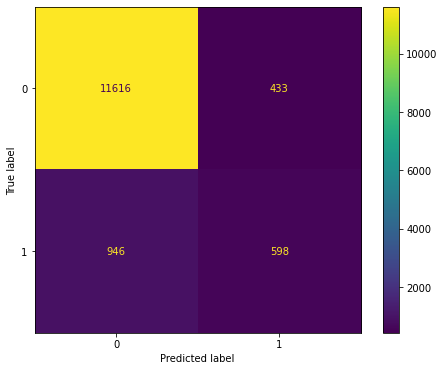

In [11]:
scores_train = eclf.score(X_train, y_train)
scores_test = eclf.score(X_test, y_test)
print('Training DataSet accuracy: {: .1%}'.format(scores_train), 'Test DataSet accuracy: {: .1%}'.format(scores_test))
plot_confusion_matrix(eclf, X_test, y_test)
plt.show()

Як  бачимо, точність тестового та навчального DataSet однакова. Це свідчить, що моделі є точними. І для підвищення точності слід додавати нові рядки до DataSet.

## Класифікація з Keras

Основна архітектура нейронної мережі глибокого навчання,  яку  будемо використовувати, складається з трьох основних компонентів.
**Input Layer**: Сюди подаються навчальні спостереження. Кількість змінних-передбаченб також задається тут за допомогою нейронів.

**Hidden Layers**:
Це проміжні шари між вхідним і вихідним шарами. Глибока нейронна мережа дізнається про зв'язки, пов'язані з даними в цьому компоненті. У наших випадках прихований шар матиме 20 нейронів.

**Output Layer**: Це шар, де остаточний результат витягується з того, що відбувається на попередніх двох шарах. У разі проблем з класифікацією вихідний шар матиме два нейрони, тому що 2 класи.

Let's import necessary libraries

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

Ми почнемо з налаштування моделі як функції. Перший рядок коду викликає конструктор Sequential. Ми використовуємо модель Sequential, тому що наша мережа складається з лінійного стеку шарів. Другий рядок коду представляє прихований шар, де ми повинні вказати кількість прихованих нейронів, що задають функцію активації, і кількість вхідних вимірювань, яка в нашому випадку дорівнює 10 предикторам. Наступний рядок коду створює вихідний шар із двома нейронами, оскільки існує два вихідних класи, 0 і 1. Ми використовуємо "softmax" як функцію активації для вихідного шару, щоб сума передбачених значень від усіх нейронів у вихідному шарі дорівнювала одиниці. У наведених вище рядках ми визначили архітектуру нашої моделі глибокого навчання. Але перш ніж ми зможемо розпочати навчання моделі, ми налаштуємо процес навчання. Це робиться в останньому рядку коду за допомогою функції model.compile(). Визначаючи наш компілятор, ми будемо використовувати "категоріальну перехресну ентропію" як міру втрат, "adam" як алгоритм оптимізатора і "точність" як метрику оцінки. Основна перевага оптимізатора "adam" полягає в тому, що нам не потрібно вказувати швидкість навчання як у випадку з градієнтним спуском. Таким чином, використання "adam" позбавить нас необхідності оптимізувати швидкість навчання для нашої моделі.

In [13]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=10, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Тепер усе готово до побудови моделі, що і зроблено у наведеному нижче коді.  Також задаємо аргумент epochs, який є кількість ітерацій навчання. Ми взяли десять епох.

In [14]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)
history = estimator.fit(X_train, y_train)

Epoch 1/10
5519/5519 [==============================] - 3s 440us/step - loss: 0.2867 - accuracy: 0.8939   

KeyboardInterrupt: 

Keras надає можливість реєструвати зворотні виклики під час навчання моделі глибокого навчання.

Одним із зворотних викликів за замовчуванням, який реєструється під час навчання всіх моделей глибокого навчання, є зворотній виклик History. Він записує метрики навчання кожної епохи. Сюди входять втрати та точність (для завдань класифікації), а також втрати та точність для тестового набору даних, якщо він заданий.

Об'єкт history повертається під час виклику функції fit(), яка використовується для навчання моделі. Метрики зберігаються у словнику.

Наприклад, можна перерахувати метрики, зібрані в об'єкті історії, за допомогою наступного фрагмента коду після навчання моделі:

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

Як видно з графіків: точність досягла максимуму, а функція втрат – мінімуму. Це означає, що модель добре підігнана і може бути використана для прогнозування

In [ ]:
from sklearn.metrics import accuracy_score

Коли модель підігнана, ми можемо прогнозувати тестові дані і обчислювати метрики оцінки.

Перший рядок коду передбачає тестових даних, другий рядок оцінює модель, а третій рядок виводить точність на тестових даних.

In [ ]:
yhat = estimator.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy))

In [ ]:
clf_name.append('KerasClassifier')
clf_acc.append(accuracy)

Як бачите, точність цієї моделі вища, ніж у всіх попередніх.

Також ми можемо збудувати confusion matrix. На жаль, у фреймворку Keras немає функції plot_confusion_matrix(). Тому ми повинні створити її за допомогою Pandas та  **[Seaborn.heatmap()](https://seaborn.pydata.org/generated/seaborn.heatmap.html)**

In [ ]:
from sklearn.metrics import confusion_matrix
# Confusion matrix
cm = pd.DataFrame(confusion_matrix(yhat, y_test))
sns.heatmap(cm, annot=True, )
plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.show()

Можна легко використовувати цю модель, яка   використовує всі 10 полів як вхідні параметри для розрахунку класу клієнтів.

Отже  класифікатор точніший, але процес припасування занадто довгий. На жаль, не можна використати цю оцінку для VotingClassifier.

Щоб використовувати ансамбль подібних класифікаторів, треба використовувати **[BaggingClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)**

In [ ]:
from sklearn.ensemble import BaggingClassifier
ensemble = BaggingClassifier(estimator, n_estimators=3, max_samples=1.0, max_features=1.0)
ensemble.fit(X_train, y_train)

У цьому прикладі ми створили ансамбль, що складається з трьох однакових класифікаторів Keras. Процес припасування використовує випадкові процеси, тому точність цих трьох класифікаторів буде трохи відрізнятися. Але ансамбль повинен показувати однаковий чи кращий результат.

In [ ]:
yhat =  ensemble.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.4f' % (accuracy))

In [ ]:
clf_name.append('BaggingClassifier')
clf_acc.append(accuracy)

Як бачимо, результат трохи кращий.

## Власний Keras ансамблевий   класифікатор

 Якщо потрібно використовувати ансамбль із різних моделей, то можна створити власний ансамбль. Для цього необхідно:

1. Створити список відповідних класифікаторів
2. Об'єднати їхні виходи
3. Використовуйте ці виходи як вхідні дані для класифікатора стека.

Давайте зробимо це

Насамперед, ми повинні створити список класифікаторів Keras. За бажанням можна використовувати різні класифікатори. Але для порівняння точності  будемо використовувати ті самі моделі keras.

In [ ]:
# fit and save models
n_members = 3
members = list()
for i in range(n_members):
    # fit model
    model = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)
    model.fit(X_train, y_train)
    members.append(model)

Давайте підрахуємо точність цих моделей:

In [ ]:
# evaluate standalone models on test dataset
for model in members:
    yhat = model.predict(X_test)
    accuracy = accuracy_score(y_test, yhat)
    print('Accuracy: %.4f' % (accuracy))

Потім ми повинні об'єднати виходи цих моделей в один DataSet, який використовуватиметься як вхід для стекового класифікатора. Давайте створимо функцію, яка буде використовувати моделі ансамблю та вхідний DataSet як вхідні параметри та повертати результати об'єднання.

In [ ]:
# create stacked model input dataset as outputs from the ensemble
from numpy import dstack
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members]
    stackX = stackX.reshape((stackX.shape[1], stackX.shape[2]))
    return stackX

Після цього ми маємо створити стековий класифікатор, який би обєднував результати членів ансамблю. Використовуємо для цього LogisticRegression та створимо функцію, яка йому відповідатиме:

In [ ]:
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = LogisticRegression()
    model.fit(stackedX, inputy)
    return model

Припасуємо  стекову модель ensemble:

In [ ]:
# fit stacked model using the ensemble
model = fit_stacked_model(members, X_test, y_test)

Для обчислення прогнозу ми повинні створити функцію, яка використовуватиме члени, функцію стека та вхідний DataSet як вхідні параметри:

In [ ]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    stackedX = stacked_dataset(members, inputX)
    yhat = model.predict(stackedX)
    return yhat

Давайте зробимо прогноз власного ансамблю:

In [ ]:
yhat = stacked_prediction(members, model, X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.4f' % (accuracy))

точність краща!

In [ ]:
clf_name.append('LinearKerasEnsemble')
clf_acc.append(accuracy)

Давайте порівняємо результати наших ансамблів:

In [ ]:
df = pd.DataFrame({'Classificators':clf_name, 'Accuracy':clf_acc})
ax = df.plot.bar(x='Classificators', y='Accuracy', rot=45)

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
df

Як бачимо, точність власного ансамблю класифікації найкраща


## Індивідуальні Завдання

Створення власного класифікатора

**Task 1** Створіть функцію користувача, яка визначає базову модель класифікатора зі стекуванням на основі нейронної мережі

In [ ]:
def stacked_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=n_members, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


**Task 2** Створіть користувацьку функцію, яка визначає ансамблеву модель на  основі   Keras Classifier

In [ ]:
def fit_stacked_model_NN(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = KerasClassifier(build_fn=stacked_model, epochs=10, batch_size=5, verbose=1)
    model.fit(stackedX, inputy)
    return model


**Task 3** Припасувати  стекову модель, використовуючи ансамбль, і розрахувати точність

In [ ]:

model = fit_stacked_model_NN(members, X_test, y_test)
yhat = stacked_prediction(members, model, X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy))

**Task 4** Порівняйте результати всіх класифікаторів

In [ ]:
clf_name.append('NNKerasEnsemble')
clf_acc.append(accuracy)
df = pd.DataFrame({'Classificators':clf_name, 'Accuracy':clf_acc})
ax = df.plot.bar(x='Classificators', y='Accuracy', rot=45)
df

## Висновки

У цій лабораторній роботі  порівнюється різні класифікатори. Також  навчилися об’єднувати їх у ансамбль. Також можна створювати власні класифікатори на основі нейронних мереж і об’єднувати їх в ансамбль. Порівнюється точність різних класифікаторів та їх ансамблів та показано, як їх можна використовувати в банківській справі на прикладах класифікації клієнтів.

Точність рішення склала близько 90%.